In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset
# please also check this: https://huggingface.co/collections/laolao77/virft-datasets-67bc271b6f2833eccc0651df
# (we can use only the 4 classification datasets)
dataset = load_dataset('jbarat/plant_species')
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
})

In [3]:
dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['aechmea_fasciata', 'agave_americana', 'agave_attenuata', 'agave_tequilana', 'aglaonema_commutatum', 'albuca_spiralis', 'allium_cepa', 'allium_sativum'], id=None)}

In [4]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset('jbarat/plant_species')

# Split the training data into train and test (let's say 20% for the test set)
train_test_split = dataset['train'].train_test_split(test_size=0.1, seed=42)

# Further split the training set to get a validation set (e.g., 10% of the training set)
train_val_split = train_test_split['train'].train_test_split(test_size=0.1, seed=42)

# Combine the splits into a new DatasetDict
final_dataset = {
    'train': train_val_split['train'],
    'val': train_val_split['test'],  # Validation set
    'test': train_test_split['test']  # Test set
}

# Display the structure of the final dataset
final_dataset

{'train': Dataset({
     features: ['image', 'label'],
     num_rows: 648
 }),
 'val': Dataset({
     features: ['image', 'label'],
     num_rows: 72
 }),
 'test': Dataset({
     features: ['image', 'label'],
     num_rows: 80
 })}

In [5]:
train_ds = final_dataset["train"]
val_ds = final_dataset["val"]
test_ds = final_dataset["test"]

In [6]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
 'label': 7}

In [7]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['aechmea_fasciata', 'agave_americana', 'agave_attenuata', 'agave_tequilana', 'aglaonema_commutatum', 'albuca_spiralis', 'allium_cepa', 'allium_sativum'], id=None)}

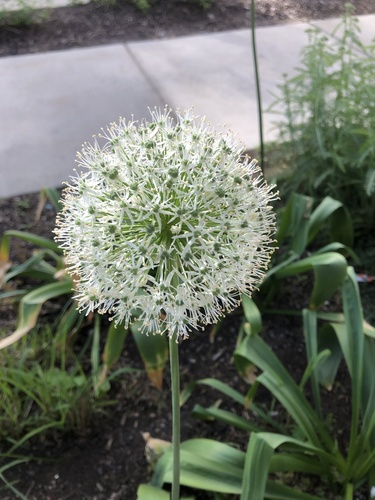

In [8]:
image = train_ds[1]['image']
image

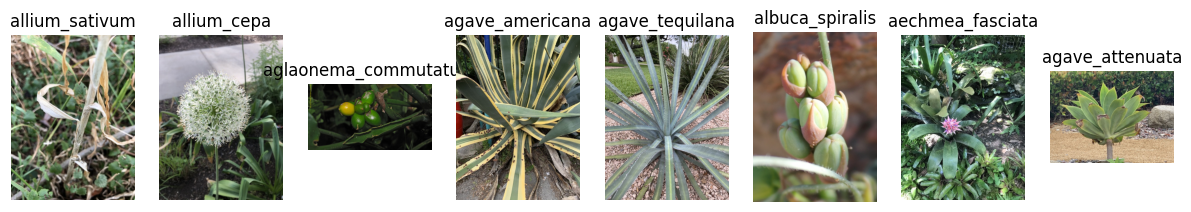

In [9]:
import matplotlib.pyplot as plt

# Initialize a set to keep track of shown labels
shown_labels = set()

# Initialize the figure for plotting
plt.figure(figsize=(15, 10))

# Loop through the dataset and plot the first image of each label
for i, sample in enumerate(train_ds):
    label = train_ds.features["label"].names[sample["label"]]
    if label not in shown_labels:
        plt.subplot(1, len(train_ds.features["label"].names), len(shown_labels) + 1)
        plt.imshow(sample["image"])
        plt.title(label)
        plt.axis("off")
        shown_labels.add(label)
        if len(shown_labels) == len(train_ds.features["label"].names):
            break

plt.show()

In [10]:
id2label = {id: label for id, label in enumerate(train_ds.features["label"].names)}
label2id = {label: id for id, label in id2label.items()}
id2label, id2label[train_ds[0]["label"]]

({0: 'aechmea_fasciata',
  1: 'agave_americana',
  2: 'agave_attenuata',
  3: 'agave_tequilana',
  4: 'aglaonema_commutatum',
  5: 'albuca_spiralis',
  6: 'allium_cepa',
  7: 'allium_sativum'},
 'allium_sativum')

In [11]:
from transformers import ViTImageProcessor

# https://huggingface.co/google/vit-base-patch16-224 (this is further fine-tuned)
# https://huggingface.co/google/vit-base-patch16-224-in21k (this one isnt fine-tuned further)

model_name = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_name)
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [12]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)
val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)
test_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

In [13]:
def apply_train_transforms(examples):
    examples["pixel_values"] = [train_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


def apply_val_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


def apply_test_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

In [14]:
train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [15]:
import torch
from torch.utils.data import DataLoader


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [16]:
batch = next(iter(train_dl))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [17]:
from transformers import ViTForImageClassification
labels  = dataset['train'].features['label'].names
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir="output-models",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=1, # later, we can set higher to 2 or 3
  fp16=True,
  save_steps=10,
  eval_steps=10,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  weight_decay=0.01,
  lr_scheduler_type="cosine", # WE ONLY TWEAK HERE. TRY MULTIPLE SCHEDULERS
  warmup_steps=10,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to=[],
  load_best_model_at_end=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
)

trainer.train()

<ipython-input-19-995430cd73f9>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
10,2.019000,1.870714
20,1.692200,1.392599
30,1.307500,1.128486
40,1.150800,1.077121


TrainOutput(global_step=41, training_loss=1.5374815405868902, metrics={'train_runtime': 55.161, 'train_samples_per_second': 11.747, 'train_steps_per_second': 0.743, 'total_flos': 5.021750962697011e+16, 'train_loss': 1.5374815405868902, 'epoch': 1.0})

In [20]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.990368664264679, 'test_runtime': 0.7712, 'test_samples_per_second': 103.736, 'test_steps_per_second': 12.967}


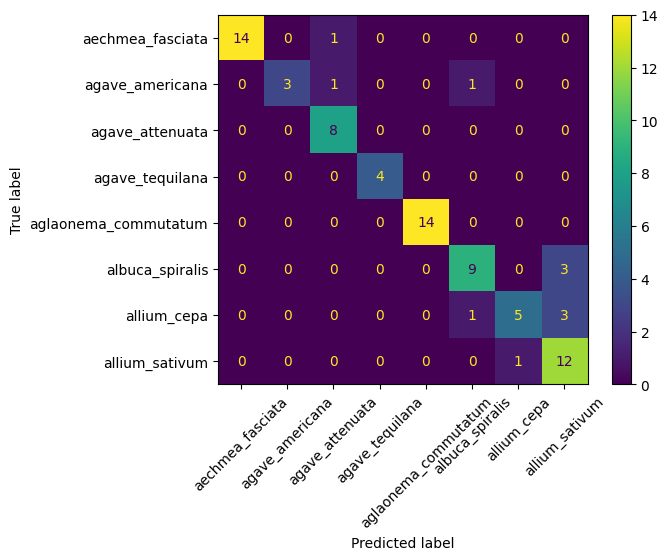

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [22]:
from sklearn.metrics import classification_report

target_names = id2label.values()

print(classification_report(y_true, y_pred, target_names=target_names))

                      precision    recall  f1-score   support

    aechmea_fasciata       1.00      0.93      0.97        15
     agave_americana       1.00      0.60      0.75         5
     agave_attenuata       0.80      1.00      0.89         8
     agave_tequilana       1.00      1.00      1.00         4
aglaonema_commutatum       1.00      1.00      1.00        14
     albuca_spiralis       0.82      0.75      0.78        12
         allium_cepa       0.83      0.56      0.67         9
      allium_sativum       0.67      0.92      0.77        13

            accuracy                           0.86        80
           macro avg       0.89      0.85      0.85        80
        weighted avg       0.88      0.86      0.86        80



In [23]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy score
accuracy = accuracy_score(y_true, y_pred)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.86
